# Mappa colori

---

## Preparazione dei dati

Leggo direttamente dai file allineati e con background parzialmente rimosso.

In [155]:
from odmr_subroutines.analysis_subroutines import *
    
def build_name (dist):
    return f"data/cristallo2_aligned_cleaned/odmr_dist_{dist}_cleaned.csv"

distanze = [17, 19, 20, 22, 24, 30, 33, 39, 40, 1000]

Raccolgo tre colonne in ciascun file: freq, od, lock. Occhio: file diversi hanno colonne di lunghezze diverse. Occorre uniformare le lunghezze prima di fare la heatmap!

In [156]:
freq_data = []
spectra_data = []
lock_in_data = []

max_lenght = -10

for i, dist in enumerate( reversed(distanze) ):
    nome = build_name(dist)
    file = leggi_file_odmr(nome) 
    freq_data.append(file['freq'].tolist())
    spectra_data.append(file['od'].tolist())
    lock_in_data.append(file['lock'].tolist())
    
    if file['freq'].size > max_lenght:
        max_lenght = file['freq'].size
        idx_max_lenght = i

Prendo il file con le colonne più lunghe. Guardo gli estremi delle frequenze. Faccio in modo che tutti gli altri file abbiano lo stesso range di frequenze e lo stesso numero di punti, semplicemente aggiungendone tanti quanti ne servono. Le frequenze tanto vanno di 0.5 in 0.5; in od e lock metto un bello 0.

In [157]:
estremo_sx = freq_data[idx_max_lenght][0]
estremo_dx = freq_data[idx_max_lenght][-1]

for i in range(len(freq_data)):
    # controllo se la colonna corrente è più corta della più lunga
    if max_lenght > len(freq_data[i]):
        # allora controllo se manca qualcosa all'inizio:
        # (viene fuori che non è possibile: partono tutti da 2500.00)
        if freq_data[i][0] > estremo_sx:
            freq_data[i][0] = [estremo_sx + j*0.25 for j in range(int(round((freq_data[i][0] - estremo_sx)/0.25)) + 1)] + freq_data[i][0]
        # poi controllo se manca qualcosa alla fine:
        if freq_data[i][-1] < estremo_dx:
            freq_data[i] += [freq_data[i][-1] + j*0.25 for j in range(1, int(round((estremo_dx - freq_data[i][-1])/0.25)) + 1)]
            spectra_data[i] += [0.0 for _ in range(len(freq_data[i]) - len(spectra_data[i]))]
            lock_in_data[i] += [0.0 for _ in range(len(freq_data[i]) - len(lock_in_data[i]))]

        # infine, controllo che siano lunghi uguali!
        if max_lenght > len(freq_data[i]):
            print(f"ERRORE: la colonna {i} ({len(freq_data[i])}) è ancora più corta della più lunga ({max_lenght})!")


ERRORE: la colonna 0 (458) è ancora più corta della più lunga (865)!


In [158]:
def interpola_colonna_mancante(freq_orig, data_orig, freq_target_step=0.25):
    """Interpola una colonna con step più grandi su una griglia più fine"""
    
    # Crea la nuova griglia con step desiderato
    freq_min, freq_max = freq_orig[0], freq_orig[-1]
    n_points = int((freq_max - freq_min) / freq_target_step) + 1
    freq_new = np.linspace(freq_min, freq_max, n_points)
    
    # Interpolazione lineare
    data_new = np.interp(freq_new, freq_orig, data_orig)
    
    return freq_new.tolist(), data_new.tolist()

print("Lunghezze prima della correzione finale:")
for i in range(len(freq_data)):
    print(f"File {i}: {len(freq_data[i])} punti")

# FORZA tutte le colonne ad avere la stessa lunghezza
target_length = max(len(col) for col in freq_data)
print(f"Lunghezza target: {target_length}")

for i in range(len(freq_data)):
    if len(freq_data[i]) != target_length:
        print(f"Correggendo file {i}: da {len(freq_data[i])} a {target_length}")
        
        # Salva originali
        freq_orig = freq_data[i].copy()
        spectra_orig = spectra_data[i].copy()
        lock_orig = lock_in_data[i].copy()
        
        # Trova il file con lunghezza target come riferimento
        idx_target = next(j for j in range(len(freq_data)) if len(freq_data[j]) == target_length)
        freq_target = freq_data[idx_target]
        
        # Interpola su questa griglia
        spectra_new = np.interp(freq_target, freq_orig, spectra_orig)
        lock_new = np.interp(freq_target, freq_orig, lock_orig)
        
        # Sostituisci
        freq_data[i] = freq_target.copy()  # Usa le stesse frequenze
        spectra_data[i] = spectra_new.tolist()
        lock_in_data[i] = lock_new.tolist()

# Verifica finale
print("Lunghezze dopo correzione:")
for i in range(len(freq_data)):
    print(f"File {i}: freq={len(freq_data[i])}, spettro={len(spectra_data[i])}, lock={len(lock_in_data[i])}")


Lunghezze prima della correzione finale:
File 0: 458 punti
File 1: 865 punti
File 2: 865 punti
File 3: 865 punti
File 4: 865 punti
File 5: 865 punti
File 6: 865 punti
File 7: 865 punti
File 8: 865 punti
File 9: 865 punti
Lunghezza target: 865
Correggendo file 0: da 458 a 865
Lunghezze dopo correzione:
File 0: freq=865, spettro=865, lock=865
File 1: freq=865, spettro=865, lock=865
File 2: freq=865, spettro=865, lock=865
File 3: freq=865, spettro=865, lock=865
File 4: freq=865, spettro=865, lock=865
File 5: freq=865, spettro=865, lock=865
File 6: freq=865, spettro=865, lock=865
File 7: freq=865, spettro=865, lock=865
File 8: freq=865, spettro=865, lock=865
File 9: freq=865, spettro=865, lock=865


Ocio! Il segnale lock-in in realtà è una derivata. Devo integrare nella frequenza.

In [159]:
from scipy.integrate import cumulative_trapezoid

'''# Integrazione rispetto alla frequenza
for i in range(len(freq_data)):
    f = np.asarray(freq_data[i].copy()).ravel()
    l = np.asarray(lock_in_data[i].copy()).ravel()
    print(np.any(np.isnan(f)), np.any(np.isnan(l)))
    print(i, f.shape, l.shape)  # controllo
    odmr_raw = cumulative_trapezoid(l, f, initial=0)'''

'# Integrazione rispetto alla frequenza\nfor i in range(len(freq_data)):\n    f = np.asarray(freq_data[i].copy()).ravel()\n    l = np.asarray(lock_in_data[i].copy()).ravel()\n    print(np.any(np.isnan(f)), np.any(np.isnan(l)))\n    print(i, f.shape, l.shape)  # controllo\n    odmr_raw = cumulative_trapezoid(l, f, initial=0)'

Riarrangio i dati

In [160]:
dists = np.array(distanze[:-1]+[60]) # distanze, da cui poi ricaverò il campo B, ma lo faccio io dopo
freq_data_col = np.column_stack(freq_data)
Z_spectro = np.column_stack(spectra_data)
Z_lockin  = np.column_stack(lock_in_data)

### Heatmap spettro normale

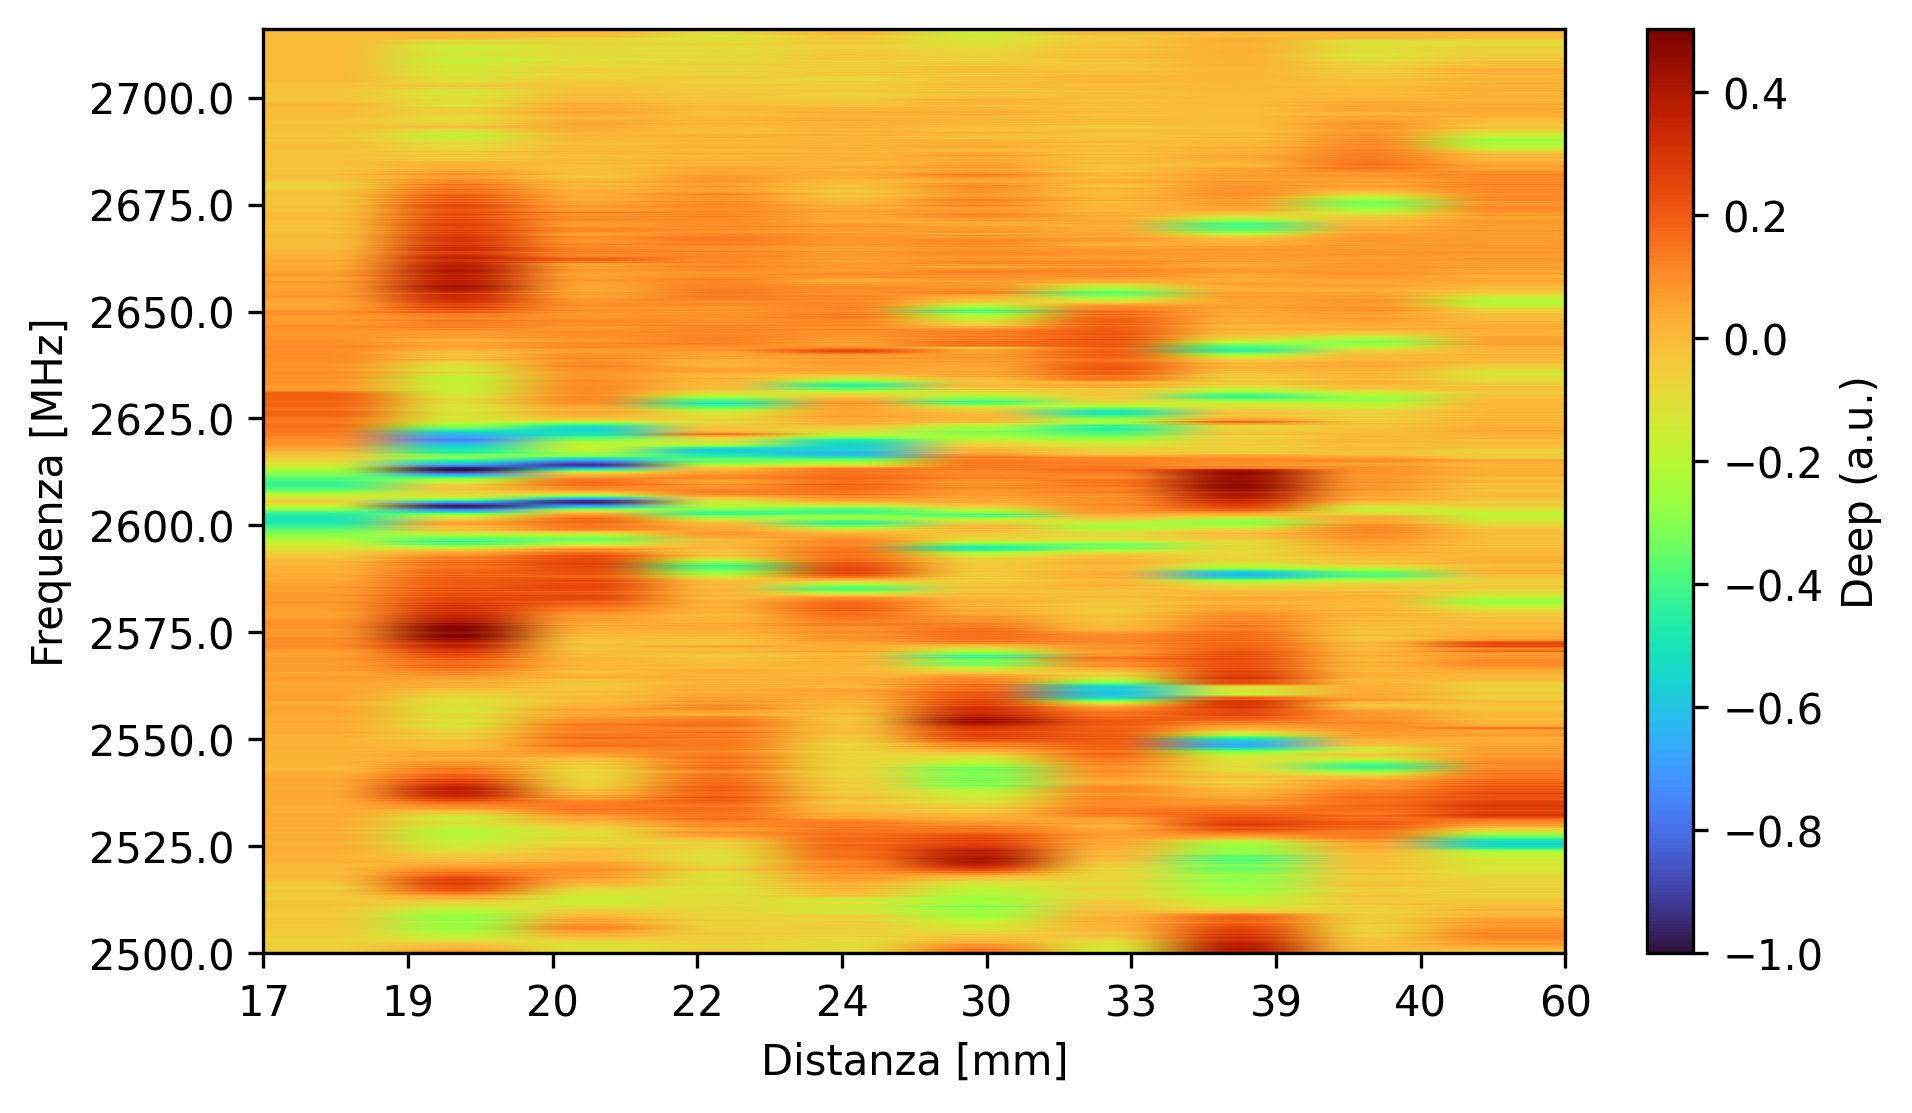

In [161]:
import matplotlib.pyplot as plt
import numpy as np

# Heatmap spettro normale
fig, ax = plt.subplots(figsize=(7,4), dpi=300)

# Usa imshow che è più semplice per questo tipo di dati
im = ax.imshow(Z_spectro, aspect='auto', cmap='turbo', 
               extent=[0, len(dists)-1, 0, Z_spectro.shape[0]-1],
               origin='lower')
cbar = fig.colorbar(im, ax=ax, label='Deep (a.u.)')

# Imposta i tick personalizzati
ax.set_xticks(range(len(dists)))
ax.set_xticklabels(dists)
ax.set_xlabel('Distanza [mm]')
ax.set_ylabel('Frequenza [MHz]')
ax.set_yticks([100*i for i in range(9)], [freq_data[0][100*i] for i in range(9)])
plt.show()

### Heatmap lockin

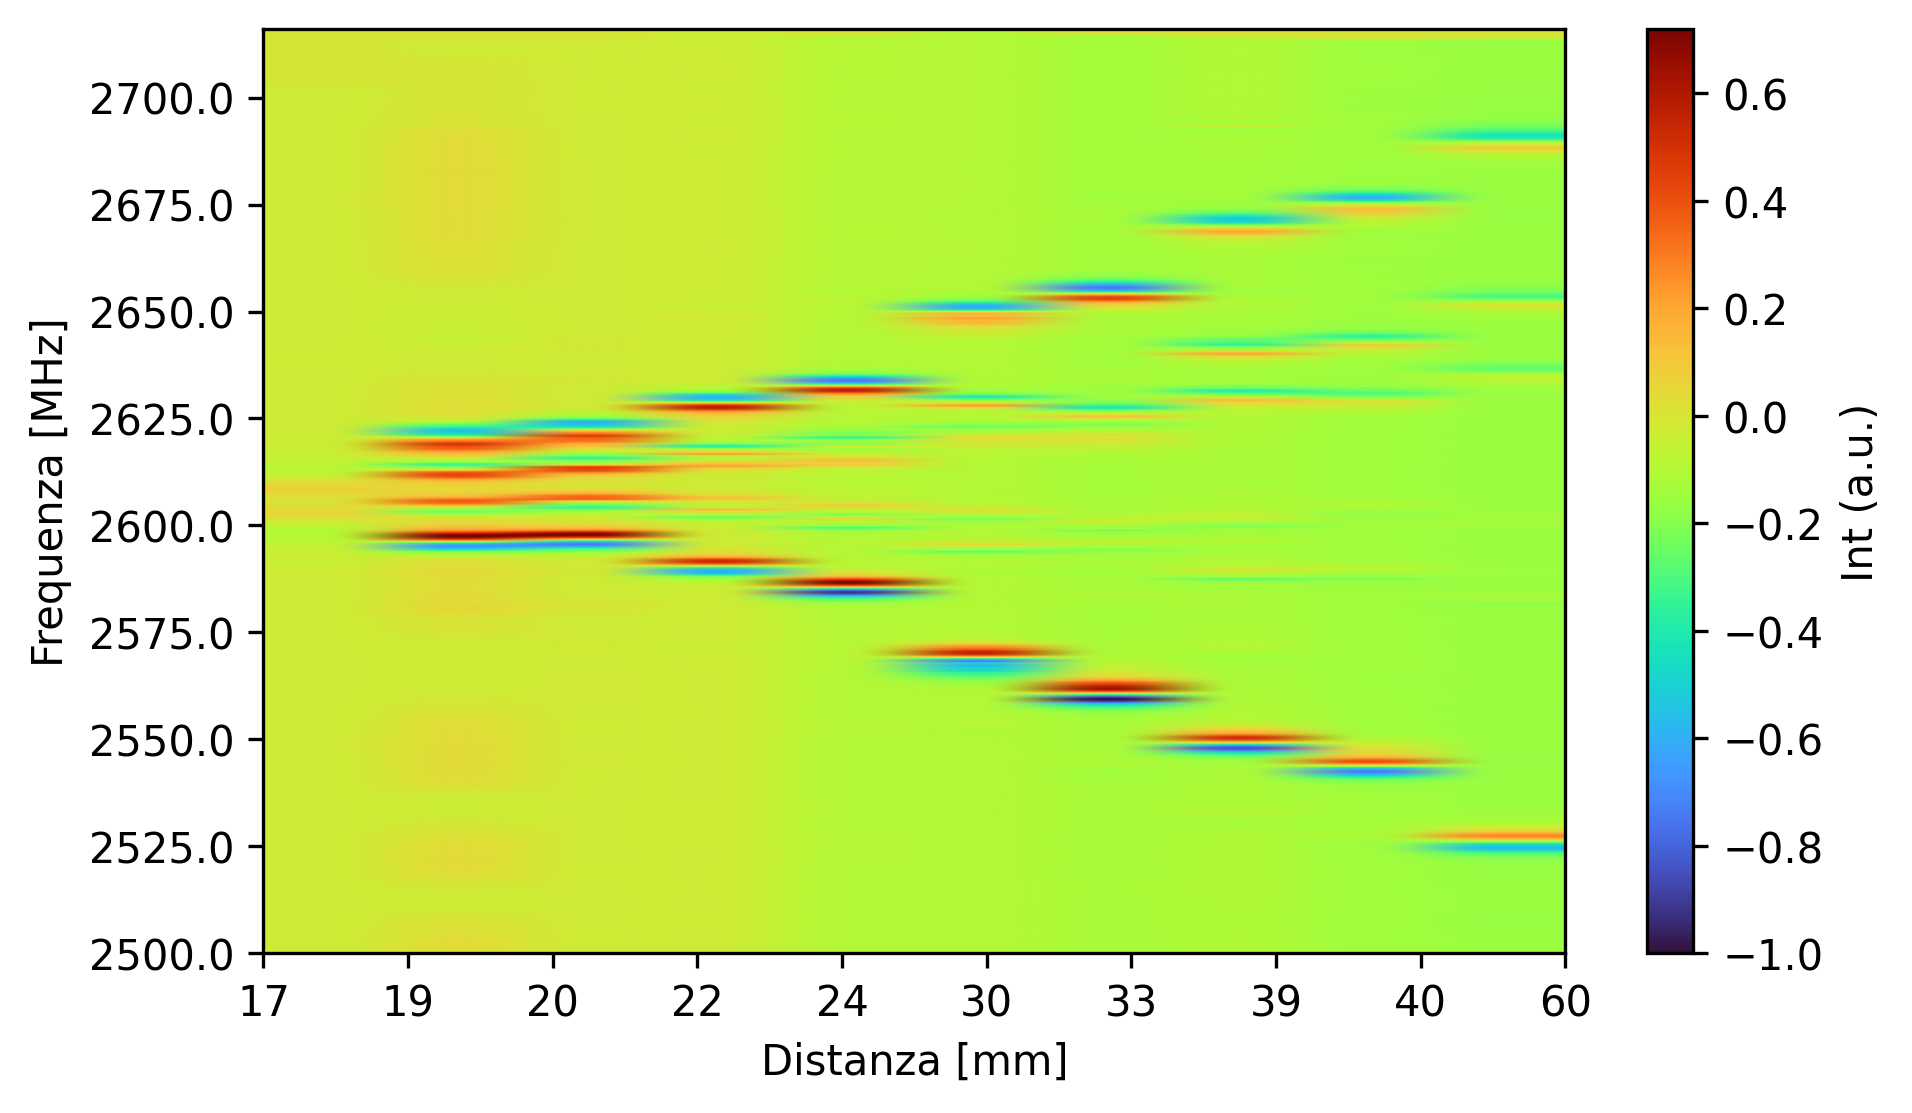

In [162]:
# Heatmap lock-in
fig, ax = plt.subplots(figsize=(7,4), dpi=300)

im = ax.imshow(Z_lockin, aspect='auto', cmap='turbo', 
               extent=[0, len(dists)-1, 0, Z_lockin.shape[0]-1],
               origin='lower')
cbar = fig.colorbar(im, ax=ax, label='Int (a.u.)')

ax.set_xticks(range(len(dists)))
ax.set_xticklabels(dists)
ax.set_xlabel('Distanza [mm]')
ax.set_ylabel('Frequenza [MHz]')
ax.set_yticks([100*i for i in range(9)], [freq_data[0][100*i] for i in range(9)])
plt.show()